$y = A sin(wx+w_0)$  
由y识别w

In [1]:
# 指定CPU跑
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import numpy as np
# tf.test.is_gpu_available()
from tensorflow.keras import Input,Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten,Dense,Dropout,Conv2D,Conv1D

In [11]:
def generate_y(w, a, w0):
    length = 300
    x = np.linspace(0, 2*pi, length)
    y = a * np.sin(w*x + w0) + np.cos(5*x)
    return y.reshape(1, length, 1).astype(np.float32), np.array(w).reshape(1,1).astype(np.float32)

def generateData(batch):
    '''
    - return Y.shape = (batch, W, channel=1), G.shape=(batch, 1)
    '''
    w_min, w_max = 0.5, 30.
    a_min, a_max = 1, 10
    w = w_min+np.random.rand()*w_max
    a = a_min+np.random.rand()*a_max
    w0 = np.random.rand()*2*np.pi
    Y,W = generate_y(w, a, w0)
    i = 1
    while True:
        w = w_min+np.random.rand()*w_max
        a = a_min+np.random.rand()*a_max
        w0 = np.random.rand()*2*np.pi
        y,w = generate_y(w, a, w0)
        Y = np.concatenate((Y,y), axis=0)
        W = np.concatenate((W,w),axis=0)
        i += 1
        if i % batch == 0:
            yield Y,W
            w = w_min+np.random.rand()*w_max
            a = a_min+np.random.rand()*a_max
            w0 = np.random.rand()*2*np.pi
            Y,W = generate_y(w, a, w0)
            i = 1

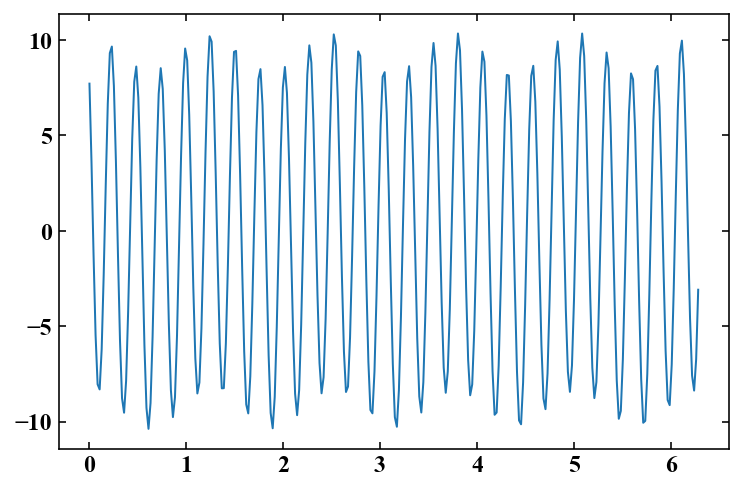

In [12]:
batch = 50
data = generateData(batch)
next(data)[0].shape
plt.plot(np.linspace(0,2*pi,300),next(data)[0][0])

In [53]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv1D(1, 5, strides=2, padding='same', input_shape=(300,))
        self.BN1 = layers.BatchNormalization(axis=2)
        self.conv2 = Conv1D(1, 5, strides=2, padding='same')
        self.BN2 = layers.BatchNormalization(axis=2)
        self.flatten = Flatten()
        self.fc1 = Dense(120, activation='relu') # 默认use_bias=True, 
        self.fc2 = Dense(120, activation='relu')

        self.out = Dense(1)
    
    def call(self, x):
        x = self.conv1(x)
        x = self.BN1(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x


my_model = MyModel()  

In [54]:
batch = 150
data = generateData(batch)

x = next(data)[0]
print('x.shape:',x.shape)
my_model(x).shape

x.shape: (150, 300, 1)


TensorShape([150, 1])

In [55]:
my_model.summary()

Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            multiple                  6         
_________________________________________________________________
batch_normalization_4 (Batch multiple                  4         
_________________________________________________________________
conv1d_9 (Conv1D)            multiple                  6         
_________________________________________________________________
batch_normalization_5 (Batch multiple                  4         
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_12 (Dense)             multiple                  9120      
_________________________________________________________________
dense_13 (Dense)             multiple                  1

In [56]:
my_model.compile(loss='mse', optimizer='Adam')

In [58]:
# 使用集成度较低的 Model.train_on_batch方法，自行设定batch数据　和　ｅpochs
for step in range(9000):
    train_data = next(data)
    cost = my_model.train_on_batch(train_data[0], train_data[1])
    if step%100==0:
        print(f'loss: {cost}')

loss: 0.33823543787002563
loss: 0.4639902114868164
loss: 0.2508959174156189
loss: 0.5491183400154114
loss: 0.2327466607093811
loss: 0.1973220258951187
loss: 0.6330323219299316
loss: 0.3103911578655243
loss: 0.487448126077652
loss: 0.08832141011953354
loss: 0.4415607750415802
loss: 1.1843512058258057
loss: 0.09420544654130936
loss: 0.11543218046426773
loss: 0.3098629117012024
loss: 0.12100174278020859
loss: 0.273427277803421
loss: 0.7311302423477173
loss: 0.4508534371852875
loss: 0.11334453523159027
loss: 0.22100596129894257
loss: 0.16947612166404724
loss: 0.19450929760932922
loss: 0.145554319024086
loss: 0.22055907547473907
loss: 0.17239603400230408
loss: 0.870945930480957
loss: 0.09081191569566727
loss: 0.16283240914344788
loss: 0.12549209594726562
loss: 0.1431257426738739
loss: 0.11720578372478485
loss: 0.41467392444610596
loss: 0.17458045482635498
loss: 0.47788679599761963
loss: 0.06805384159088135
loss: 0.08211590349674225
loss: 0.08703477680683136
loss: 0.10490559786558151
loss: 0

In [67]:
test_data = next(data)
tx = test_data[0]
ty = test_data[1]
test_x=tx[0].reshape(1,300,1)

print('True:',ty[0],
      'predict:',my_model.predict(test_x))

True: [29.242176] predict: [[30.059973]]
